# Liqi Challenge - Data Scientist & Engineer role - Leonardo Iania

Obiettivo: la società ABC ha richiesto un prestito a breve termine (<12 mesi).

Dovremmo accettare? Qual è l'importo massimo che possiamo fornirgli?

Per quanto riguarda i dati societari a disposizione, viene fornito l'ultimo financial statement (al 31/12 del 2021) e le transazioni effettuate nel 2022.

## 1. Lettura dati e parsing del financial statement

Mentre la lettura delle transazioni è relativamente facile, in quanto è scaricabile in formato .csv, il financial statement è un XML che contiene il documento XBRL.

Per leggere i dati contenuti in quest'ultimo ho utilizzato la libreria [Python XBRL](https://pypi.org/project/python-xbrl/).

In [ ]:
%%capture
!pip install python-xbrl
from xbrl import XBRLParser, GAAP, GAAPSerializer, DEISerializer
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #hide seaborn warnings

In [ ]:
xbrl_parser = XBRLParser()
xbrl = xbrl_parser.parse(open("bilancio_test (2).xml"))

In [ ]:
custom_obj = xbrl_parser.parseCustom(xbrl)

Ora possiamo utilizzare un pandas dataframe per leggere tutte le voci e i relativi valori direttamente:

In [ ]:
df = pd.DataFrame(custom_obj())
df.head()

,0,1
0,patrimonionettoutileperditaesercizio,\n -94264\n
1,utileperditaesercizio,\n -94264\n
2,differenzavalorecostiproduzione,\n -94264\n
3,risultatoprimaimposte,\n -94264\n
4,totalecreditiversosociversamentiancoradovuti,\n 33\n


Mentre la colonna dei nomi, anche se senza spazi, è abbastanza chiara, quella dei valori è meno leggibile e sopratutto non mi permette di fare operazioni numeriche, quindi la trasformo:

In [ ]:
col_one = df.iloc[:,1].tolist()

for i in range(len(col_one)):
  col_one[i] = int(col_one[i])

df.iloc[:,1] = col_one

df.head()

,0,1
0,patrimonionettoutileperditaesercizio,-94264
1,utileperditaesercizio,-94264
2,differenzavalorecostiproduzione,-94264
3,risultatoprimaimposte,-94264
4,totalecreditiversosociversamentiancoradovuti,33


Ora andiamo a vedere nel dettaglio tutte le voci (78), che per comodità dividiamo in due metà:

In [ ]:
n=df.shape[0]
print(df.iloc[0:int(n/2),:].to_string())

                                                                                               0         1
0                                                           patrimonionettoutileperditaesercizio    -94264
1                                                                          utileperditaesercizio    -94264
2                                                                differenzavalorecostiproduzione    -94264
3                                                                          risultatoprimaimposte    -94264
4                                                   totalecreditiversosociversamentiancoradovuti        33
5                                                                        patrimonionettocapitale       209
6                                                       valoreproduzionealtriricaviproventialtri       260
7                                                            costiproduzioneoneridiversigestione       939
8                                    

In [ ]:
print(df.iloc[int(n/2):,:].to_string())

                                                                                 0  1
38                                                          amministratoricompensi  0
39                                                           amministratoricrediti  0
40                    amministratoriimpegniassuntilorocontoeffettogaranzieprestate  0
41                                                            sindacianticipazioni  0
42                                                                 sindacicompensi  0
43                                                                  sindacicrediti  0
44                           sindaciimpegniassuntilorocontoeffettogaranzieprestate  0
45                                                                 garanzieimporto  0
46                                                                   garanziereali  0
47                                                impegniconfrontiimpresecollegate  0
48                                             impegni

Nella seconda parte, tutti i valori sono uguali a 0. Questi dati sono utili a capire che l'azienda ha una certa "stabilità" finanziaria e non è nè controllata nè controlla altre aziende da cui potrebbe essere influenzata.

Dalla prima parte, invece, i dati rilevanti su cui è utile concentrarsi sono:

* Risultato d'esercizio: l'azienda nel 2021 ha subito una perdita rilevante, concludendo l'anno con -94264. Da qui è importante vedere se l'azienda ha dei crediti che ancora devono essere riscossi e se, dalle transazioni 2022, continua ad essere in perdita e/o riesce a coprirla.
* crediti esigibili entro il 2022: ammontano a 87895, quasi da soli potrebbero coprire la perdita del 2021. Questo è, ovviamente, un dato di cui tenere conto.
* debiti: sono in totale 139241, tutti esigibili entro l'esercizio successivo. Ci sarà da valutare, nelle transazioni 2022, se l'azienda sarà in grado o meno di ripagarli.
* Disponibilità liquide: sono 54891, ovviamente è un ottimo indicatore della possibilità di ripagare debiti e insieme ai crediti di cui sopra più 3000 di rimanenze vanno a costituire il totale dell'attivo circolante (145786).

Andiamo più nel dettaglio:

## Analisi financial statement

### Risultato d'esercizio:

Oltre a notare la perdita in sè, è utile capire a quanto ammonta il valore della produzione rispetto ai costi:

In [ ]:
df.set_index(1)

print(df.index)

RangeIndex(start=0, stop=76, step=1)


In [ ]:
df[df[0].str.contains('totalevaloreproduzione')]

,0,1
24,totalevaloreproduzione,118315


In [ ]:
df[df[0].str.contains('totalecostiproduzione')]

,0,1
30,totalecostiproduzione,212579


Come sono composti? Nel dettaglio:

In [ ]:
df[df[0].str.contains('valoreproduzione')]

,0,1
6,valoreproduzionealtriricaviproventialtri,260
11,valoreproduzionevariazionirimanenzeprodotticor...,3000
12,valoreproduzionevariazionirimanenzeprodotticor...,3000
13,valoreproduzionealtriricaviproventicontributic...,4000
14,valoreproduzionealtriricaviproventitotalealtri...,4260
23,valoreproduzionericavivenditeprestazioni,111055
24,totalevaloreproduzione,118315


Per essere precisi, nel sub-dataframe di sopra sono inclusi i lavori in corso su ordinazione e il totale degli "altri ricavi" che sono presenti anche singolarmente, escludendo queste due voci possiamo vedere la composizione dei ricavi:

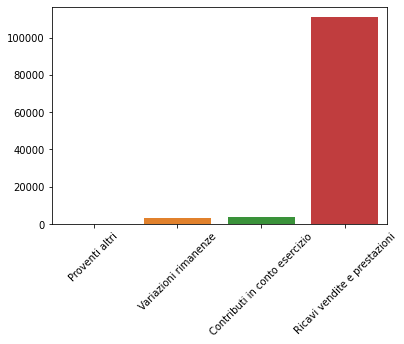

In [ ]:
idx = [6,11,13,23] #indici voci da analizzare
valpro = df[df[0].str.contains('valoreproduzione')][0][idx]
ax = sns.barplot(valpro, 
                 y = df[df[0].str.contains('valoreproduzione')][1][idx],
                 x = df[df[0].str.contains('valoreproduzione')][0][idx])
ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels(['Proventi altri','Variazioni rimanenze','Contributi in conto esercizio', 'Ricavi vendite e prestazioni']);
ax.set(xlabel='', ylabel='');

Come prevedibile, quasi tutti i ricavi vengono dalle vendite.

In [ ]:
df[df[0].str.contains('costiproduzione')]

,0,1
2,differenzavalorecostiproduzione,-94264
7,costiproduzioneoneridiversigestione,939
18,costiproduzionematerieprimesussidiarieconsumom...,75461
26,costiproduzioneservizi,136179
30,totalecostiproduzione,212579


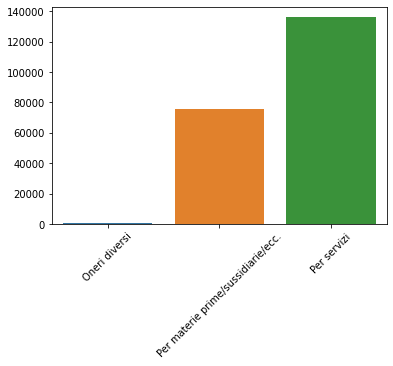

In [ ]:
idx = [7,18,26] #indici voci da analizzare
costpro = df[df[0].str.contains('costiproduzione')][0][idx]
ax = sns.barplot(costpro, 
                 y = df[df[0].str.contains('costiproduzione')][1][idx],
                 x = df[df[0].str.contains('costiproduzione')][0][idx])
ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels(['Oneri diversi','Per materie prime/sussidiarie/ecc.','Per servizi']);
ax.set(xlabel='', ylabel='');

Dopo una prima analisi del bilancio 2021, passiamo alle transazioni 2022 per vedere se l'azienda mostra segni di miglioramento.

## Analisi transazioni 2022

In [ ]:
tra = pd.read_csv("Transazioni_Azienda ABC - Foglio1.csv")

In [ ]:
tra.head()

,data,categoria,amount
0,04/01/2022,INCASSO FATTURA,"€ 5.000,00"
1,13/01/2022,INCASSO FATTURA,"€ 4.800,00"
2,15/01/2022,STIPENDI,"-€ 6.000,00"
3,15/01/2022,RIMBORSO FINANZIAMENTO,"-€ 1.200,00"
4,22/01/2022,INCASSO FATTURA,"€ 5.400,00"


In questo documento sono riportate diverse operazioni relative all'anno 2022.

Vediamo innanzitutto di che tipo di operazioni si tratta:

In [ ]:
tra['categoria'].unique()

array(['INCASSO FATTURA', 'STIPENDI', 'RIMBORSO FINANZIAMENTO', 'UTENZE',
       'PAGAMENTO FORNITORI', 'EROGAZIONE FINANZIAMENTO',
       'PAGAMENTO FATTURA'], dtype=object)

Prima di fare qualsiasi operazione, abbiamo bisogno di trasformare le stringhe relative ai valori di ogni operazioni in floating numbers:

In [ ]:
amount = tra.iloc[:,2].tolist()
float_amount = [float(s.replace('.', '').replace('€', '').replace(',','.').replace('- ','-')) for s in amount]
tra['amount'] = float_amount

In [ ]:
tra.head()

,data,categoria,amount
0,04/01/2022,INCASSO FATTURA,5000.0
1,13/01/2022,INCASSO FATTURA,4800.0
2,15/01/2022,STIPENDI,-6000.0
3,15/01/2022,RIMBORSO FINANZIAMENTO,-1200.0
4,22/01/2022,INCASSO FATTURA,5400.0


Innanzitutto andiamo a vedere il cashflow generale, cioè il risultato finale di **TUTTE** le operazioni del 2022:

In [ ]:
sum(tra['amount'])

7525.14000000001

Si può già notare che non vi è una perdita, anche se l'importo è relativamente basso.
Questo importo però non tiene conto di alcuni fattori, è necessario quindi analizzare più nel dettaglio le operazioni.

### Incassi:
Partiamo da questa categoria, ricordandoci che a fine 2021 c'erano dei crediti esigibili entro il 2022.


In [ ]:
inca = tra.loc[tra['categoria'] == 'INCASSO FATTURA']
sum(inca['amount'])

363533.46

Il totale incassato nel 2022 è 363533.46, ma di questi i crediti esigibili al 31/12/21 erano 87895. Ciò significa che il 24% circa degli incassi è relativo ad operazioni effettuate l'anno precedente.

La differenza tra questi importi, pari a 275638.46, equivale ai ricavi relativi a operazioni dell'anno corrente. 

### Pagamenti

Il primo punto che andremo a guardare concerne il pagamento di fornitori e di fatture:

In [ ]:
pag_for = tra.loc[tra['categoria'] == 'PAGAMENTO FORNITORI']
sum(pag_for['amount'])

-253042.01

In [ ]:
pag_fat = tra.loc[tra['categoria'] == 'PAGAMENTO FATTURA']
sum(pag_fat['amount'])

-40000.0

In [ ]:
sum(pag_for['amount'])+sum(pag_fat['amount'])

-293042.01

In totale vi sono pagamenti ai fornitori per 253042.01 e pagamenti di fatture per 40000.

Sommandoli si ottiene 293042.01

Questo importo però, con lo stesso ragionamento di prima, non tiene conto dei debiti contratti nell'esercizio precedente riscuotibili entro il 2022, che sono 139241. Inoltre, il fatto che il totale debiti sia costituito da questi, fa capire che l'azienda li ha coperti tutti nel 2022.

Tra questi inoltre va tenuto conto anche delle voci di **rimborso finanziamento**:

In [ ]:
tra[tra['categoria'].str.contains('FINANZIAMENTO')]

,data,categoria,amount
3,15/01/2022,RIMBORSO FINANZIAMENTO,-1200.0
11,15/02/2022,RIMBORSO FINANZIAMENTO,-1200.0
20,15/03/2022,RIMBORSO FINANZIAMENTO,-1200.0
31,15/04/2022,RIMBORSO FINANZIAMENTO,-1200.0
40,15/05/2022,RIMBORSO FINANZIAMENTO,-1200.0
46,30/05/2022,EROGAZIONE FINANZIAMENTO,10000.0
52,15/06/2022,RIMBORSO FINANZIAMENTO,-1700.0
61,15/07/2022,RIMBORSO FINANZIAMENTO,-1700.0
70,15/08/2022,RIMBORSO FINANZIAMENTO,-1700.0
81,15/09/2022,RIMBORSO FINANZIAMENTO,-1700.0


Vi è infatti un finanziamento relativo al 2021, contato tra i debiti esigibili nel 2022, che è rimborsato al 15/05, per un totale di 

1200 x 5 = 6000.

Da maggio vi è un finanziamento di 10000 che viene ripagato entro l'anno per un totale di 11900.

Per concludere questa parte, quindi:

Considerando il totale dei pagamenti nel 2022 si ha:

* 253042.01 (pagamenti ai fornitori)
* 17900 (totale rimborso finanziamenti) - di cui 6000 per il 2021
* 40000 (pagamenti fatture)

Per un totale di: 310942

Di questi, 139241 sono relativi ad operazioni del 2021.

Scorporandoli, si ottiene come risultato:

310942 - 139241 = 171701

Ritornando alla questione ricavi anno corrente, vediamo che l'azienda per quanto riguarda le operazioni puramente "core business" ottiene un risultato pari a:

275638.46 - 171701 = 103937.46

> Cosa indica? 

Questo risultato è interpretabile come "cashflow" riguardante solo ciò che accade all'azienda durante il 2022, che fa ovviamente ben sperare considerato che invece nel 2021 il risultato era stato **ben più negativo**.

Non si può però non tener conto di due fattori: utenze e stipendi.

Vediamo prima a quanto ammontano:

In [ ]:
ute = tra.loc[tra['categoria'] == 'UTENZE']
sum(ute['amount'])

-9066.31

In [ ]:
stip = tra.loc[tra['categoria'] == 'STIPENDI']
sum(stip['amount'])

-46000.0

103937.46 - 9066.31 - 46000 = 48871.15

Questo è un risultato più complessivo, in quanto le utenze e gli stipendi del 2022 pur essendo costi "indiretti" nella produzione sono sostenuti per ottenere i risultati durante l'esercizio.

Da qui vediamo che comunque l'azienda recupera dall'anno precedente.

Vi è un ultimo elemento da considerare: il finanziamento da 10000 ricevuto a maggio:

### Finanziamento

In [ ]:
erog_f = tra.loc[tra['categoria'] == 'EROGAZIONE FINANZIAMENTO']
sum(erog_f['amount'])

10000.0

Per questo finanziamento, come mostrato precedentemente, si pagherà un rimborso totale di 11900, il che significa che l'azienda **spende 1900 euro** per ottenere quei 10000.

## Conclusione

Prevedendo comunque un miglioramento per il 2023, e considerando la particolarità dell'anno 2021 (ad esempio per il covid) concluso in perdita, ci si potrebbe anche sbilanciare sull'importo da erogare.

Ma, per tenersi entro un ragionevole **margine di rischio** e considerato il risultato specifico del 2022 e sopratutto anche le disponibilità liquide che l'azienda riporta al 31/12/2021 (pari a 54891), ritengo sia corretto erogare come **importo massimo** alla ABC Company €50.000, rientrando nel **pacchetto Classic** offerto da Liqi - monitorando i risultati e valutando una eventuale estensione dell'importo già considerando il cashflow dei primi mesi del 2023, se necessario.